In [ ]:
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
#from

In [ ]:
class User():
  def give_algorithm(algo):
    if algo == "A":
      return np.random.lognormal(3, .5, 1)[0]
    elif algo == "B":
      return np.random.lognormal(3.01, .5, 1)[0]
    elif algo == "C":
      return np.random.lognormal(3.1, .51, 1)[0]
    elif algo == "D":
      return np.random.lognormal(3, .49, 1)[0]

In [ ]:
dist_A = []
dist_B = []
dist_C = []
dist_D = []

for x in range(1000000):
  dist_A.append(User.give_algorithm("A"))
  dist_B.append(User.give_algorithm("B"))
  dist_C.append(User.give_algorithm("C"))
  dist_D.append(User.give_algorithm("D"))

(-14.332367107275573, 100.0)

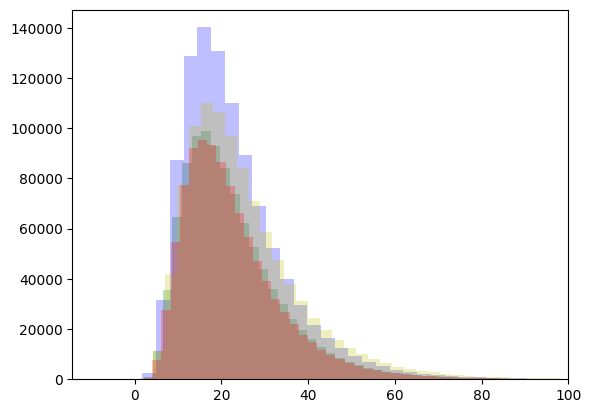

In [ ]:
plt.hist(dist_A, bins = 100, alpha = .25, color = "g")
plt.hist(dist_B, bins = 100, alpha = .25, color = "b")
plt.hist(dist_C, bins = 100, alpha = .25, color = "y")
plt.hist(dist_D, bins = 100, alpha = .25, color = "r")
plt.xlim(right = 100)

In [ ]:
print(np.mean(dist_A))
print(np.mean(dist_B))
print(np.mean(dist_C))
print(np.mean(dist_D))

22.775858294355583
22.980722177947698
25.28295840560291
22.647129838491136


In [ ]:
def reset_rewards(arms):
  rewards = {}
  for arm in arms:
    rewards[arm] = []
  return rewards, []

In [ ]:
def get_average_rewards(rewards):
  averages = {}
  for reward in rewards.keys():
    if len(rewards[reward])>0:
      averages[reward] = np.mean(rewards[reward])
    else:
      averages[reward] = np.inf
  return averages

Let's start by trying each algorithm once

In [ ]:
algorithms = ["A","B", "C", "D"]

In [ ]:
rewards, action_plays = reset_rewards(algorithms)

action_0 = "A"
user_0_minutes = User.give_algorithm(action_0)
action_plays.append(action_0)
rewards[action_0].append(user_0_minutes)

action_1 = "B"
user_1_minutes = User.give_algorithm(action_1)
action_plays.append(action_1)
rewards[action_1].append(user_1_minutes)

action_2 = "C"
user_2_minutes = User.give_algorithm(action_2)
action_plays.append(action_2)
rewards[action_2].append(user_2_minutes)

action_3 = "D"
user_3_minutes = User.give_algorithm(action_3)
action_plays.append(action_3)
rewards[action_3].append(user_3_minutes)


How well did each algorithm do?

In [ ]:
get_average_rewards(rewards)

{'A': 11.685781728864484,
 'B': 14.795068294300114,
 'C': 29.865899620905278,
 'D': 15.519510789858005}

Now, maybe we try the best algorithm

In [ ]:
action_4 = "B"
user_4_minutes = User.give_algorithm(action_4)
print(user_4_minutes)
action_plays.append(action_4)
rewards[action_4].append(user_4_minutes)

45.39143914608693


We could go on like this, but is there a more systematic way to choose which algorithm to serve a given user?

**Enter bandits** (multi-armed bandit, k-armed bandit)

Bandit algorithms are meant to balance **exploration** and **exploitation** in a systematic way to maximize the long term profit/reward

**Explore then commit**

In [ ]:
arms = algorithms

In [ ]:
rewards, action_plays = reset_rewards(algorithms)
averages = get_average_rewards(rewards)
max_action = None
for user_number in range(10000):
  #explore for the first 5000 users
  if user_number < 5000:
    action = np.random.choice(arms)
    max_action = max(averages, key=averages.get)
  else:

    action = max_action

  reward = User.give_algorithm(action)
  action_plays.append(action)
  rewards[action].append(reward)
  averages = get_average_rewards(rewards)

In [ ]:
def plot_share_over_time(action_plays, total_actions,time_kernel = 100):

  x = [0]
  y = [[.25,.25,.25,.25]]
  counts = {}
  for action in total_actions:
    counts[action] = 0

  for t in range(len(action_plays)):
    action = action_plays[t]
    counts[action] += 1
    if t % time_kernel == 0 and t != 0:
      y_value = []
      for action in counts.keys():
        y_value.append(counts[action]/time_kernel)
      x.append(t)
      y.append(y_value)
      for action in total_actions:
        counts[action] = 0

  x = np.array(x)
  y = np.array(y).T
  print(x.shape)

  plt.stackplot(x,y, labels=total_actions)
  plt.legend()
  plt.show()



In [ ]:
def get_lost_minutes(action_plays):
  n_users = len(action_plays)
  actual_total = 0
  optimal_total = 0
  for action in action_plays:
    C_play = User.give_algorithm("C")
    optimal_total += C_play
    if action == "C":
      actual_total+=C_play
    else:
      actual_total+=User.give_algorithm(action)
  print("Over %s users, you were %s minutes from the optimal"%(len(action_plays),optimal_total-actual_total))


(100,)


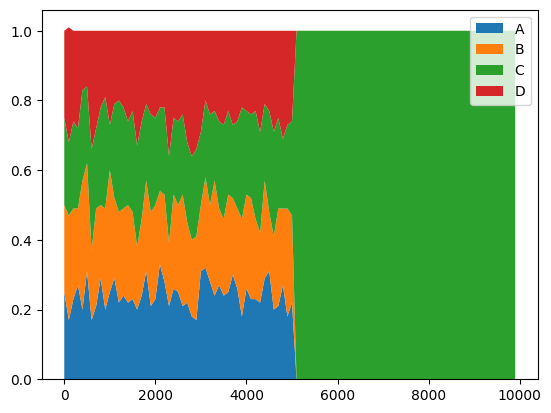

In [ ]:
plot_share_over_time(action_plays, ["A","B","C","D"])

In [ ]:
get_lost_minutes(action_plays)

Over 10000 users, you were 10014.775632999605 minutes from the optimal


Epsilon-Greedy

In [ ]:
rewards, action_plays = reset_rewards(algorithms)
max_action = None
eps = .1
for user_number in range(10000):
  rand = np.random.uniform(size= 1)[0]
  if rand < eps:
    action = np.random.choice(arms)
  else:
    action = max(averages, key=averages.get)

  reward = User.give_algorithm(action)
  action_plays.append(action)
  rewards[action].append(reward)
  averages = get_average_rewards(rewards)

(100,)


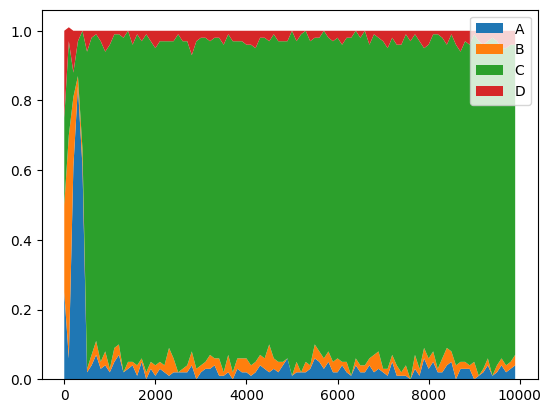

In [ ]:
plot_share_over_time(action_plays, ["A","B","C","D"])

In [ ]:
get_lost_minutes(action_plays)

Over 10000 users, you were 3016.4841355721583 minutes from the optimal


**Upper Confidence Bound**

In [ ]:
def get_upper_confidence_bound(rewards, c):
  UCBs = {}
  T = 0
  for action in rewards.keys():
    T += len(rewards[action])
  for action in rewards.keys():
    if len(rewards[action]) == 0:
      UCBs[action] = np.inf
    else:
      UCBs[action] = np.mean(rewards[action]) + c*np.sqrt(np.log(T)/len(rewards[action]))
  return UCBs

In [ ]:
rewards, action_plays = reset_rewards(algorithms)
max_action = None
eps = .1
for user_number in range(10000):
  UCBs = get_upper_confidence_bound(rewards,8)
  action = max(UCBs, key=UCBs.get)
  reward = User.give_algorithm(action)
  action_plays.append(action)
  rewards[action].append(reward)
  averages = get_average_rewards(rewards)

(100,)


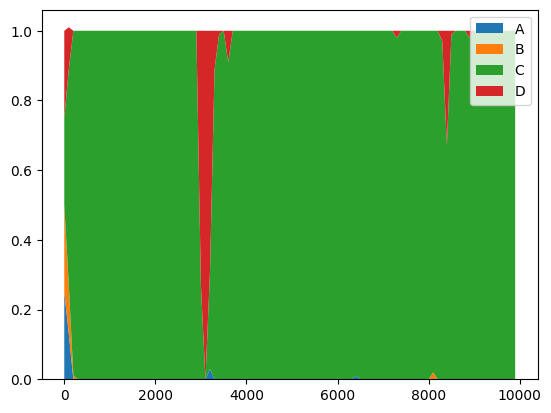

In [ ]:
plot_share_over_time(action_plays, ["A","B","C","D"])

In [ ]:
get_lost_minutes(action_plays)

Over 10000 users, you were 1249.877455615264 minutes from the optimal
